# Estimate the cost of using closed-source models on the MediaTree dataset

In [2]:
import pandas as pd

In [16]:
# https://openai.com/api/pricing/
# https://www.anthropic.com/pricing#anthropic-api
pricing = {
    'gpt-4o-mini': {
        'input': 0.15,
        'output': 0.6,
        'cache_discount': 0.5
    },
    'claude-3.5-haiku': {
        'input': 0.25,
        'output': 1.25,
        'cache_discount': 0.1
    },
}

In [3]:
df = pd.read_parquet('mediatree_raw_1year.parquet') # download from https://drive.google.com/drive/folders/1d0idkOmMIXabj7ajYhvkitMMHnH_woSN
df.head()

,start,plaintext,channel_name,channel_title,channel_radio,num_characters,num_words,num_tokens,num_tokens_approx
0,2023-09-13 06:02:00,avec un pronostic vital plus que engagé l' inc...,itele,i>Télé,False,2317,443,516,590
1,2023-09-13 04:58:00,amour un peu de love et de tendresse finalemen...,itele,i>Télé,False,1804,341,398,454
2,2023-09-13 06:04:00,autre sont en réanimation suite à des cas de b...,itele,i>Télé,False,2264,431,506,574
3,2023-09-13 04:14:00,d' être avec nous dans un instant valeo au euh...,itele,i>Télé,False,1418,285,322,380
4,2023-09-13 06:42:00,un gros tiers aux élections professionnelles m...,itele,i>Télé,False,2199,407,472,542


In [4]:
print("Nombres de passages de 2 min :", len(df))
print("Nombre de chaînes :", df.channel_name.nunique())
df.channel_name.unique()

Nombres de passages de 2 min : 354189
Nombre de chaînes : 2


array(['itele', 'sud-radio'], dtype=object)

In [5]:
avg_tokens = df.num_tokens.mean()
print("Nombre moyen de tokens :", avg_tokens)

Nombre moyen de tokens : 474.4648676271708


In [21]:
def get_cost(input_tokens: int, output_tokens: int, prompt_tokens: int, model: str) -> dict:
    prices = pricing[model]
    it_cost = input_tokens * prices['input'] / 1e6
    ot_cost = output_tokens * prices['output'] / 1e6
    prompt_cost = prompt_tokens * prices['input'] * prices['cache_discount'] / 1e6
    return {
        'total_cost': it_cost + ot_cost + prompt_cost,
        'input_cost': it_cost,
        'output_cost': ot_cost,
        'prompt_cost': prompt_cost,
        'model': model
    }

In [7]:
import tiktoken
encoding = tiktoken.encoding_for_model('gpt-4o-mini')

In [8]:
EXAMPLE_PROMPT = """
Tu es expert en désinformation sur les sujets environnementaux, expert en science climatique et sachant tout sur le GIEC. Je vais te donner un extrait d'une retranscription de 2 minutes d'un flux TV ou Radio. 
A partir de cet extrait liste moi tous les faits/opinions environnementaux (claim) uniques qu'il faudrait factchecker. Et pour chaque claim, donne une première analyse si c'est de la désinformation ou non, un score si c'est de la désinformation, ainsi qu'une catégorisation de cette allégation.
Ne sélectionne que les claims sur les thématiques environnementales (changement climatique, transition écologique, énergie, biodiversité, pollution, pesticides, ressources (eau, minéraux, ..) et pas sur les thématiques sociales et/ou économiques
Renvoie le résultat en json sans autre phrase d'introduction ou de conclusion avec à chaque fois les champs suivants : 

- "claim" - l'allégation à potentiellement vérifier
- "context" - reformulation du contexte dans laquelle cette allégation a été prononcée (maximum 1 paragraphe)
- "analysis" - première analyse du point de vue de l'expert sur le potentiel de désinformation de cette allégation en fonction du contexte
- "disinformation_score" - le score de désinformation (voir plus bas)
- "disinformation_category" - la catégorie de désinformation (voir plus bas)
- "pro_anti" - si l'allégation est plutôt anti-écologie ou pro-écologie
- "speaker" - nom et fonction de la personne qui a prononcé l'allégation si on a l'information (sinon "N/A")
- "contradiction" - si l'allégation a été contestée dans un dialogue, résume la contradiction (sinon "N/A")
- "quote" - la citation exacte qui correspond à l'allégation

Pour les scores "disinformation_score"
- "very low" = pas de problème, l'allégation n'est pas trompeuse ou à risque. pas besoin d'investiguer plus loin
- "low" = allégation qui nécessiterait une vérification et une interrogation, mais sur un sujet peu important et significatif dans le contexte des enjeux écologiques (exemple : les tondeuses à gazon, 
- "medium" = allégation problématique sur un sujet écologique important (scientifique, impacts, élections, politique, transport, agriculture, énergie, alimentation, démocratie ...) , qui nécessiterait vraiment d'être vérifiée, déconstruite, débunkée et interrogée. En particulier pour les opinions fallacieuses
- "high" = allégation grave, en particulier si elle nie le consensus scientifique

Pour les catégories de désinformation "disinformation_category": 
- "consensus" = négation du consensus scientifique
- "facts" = fait à vérifier, à préciser ou contextualiser
- "narrative" = narratif fallacieux ou opinion qui sème le doute (par exemple : "les écolos veulent nous enlever nos libertés")
- "other"

"""

prompt_tokens = len(encoding.encode(EXAMPLE_PROMPT))
prompt_tokens

636

In [9]:
N_CHANNELS = 19
N_HOURS = 800
SAMPLE_LENGTH_MIN = 2

n_samples_per_hour = 60 / SAMPLE_LENGTH_MIN
total_samples = N_CHANNELS * N_HOURS * n_samples_per_hour
total_input_tokens = round(total_samples * avg_tokens)
total_input_tokens

216355980

In [33]:
output_tokens_range = [10, 50, 100, 200, 500, 800, 1000]
costs = [get_cost(total_input_tokens, ot * total_samples, prompt_tokens * total_samples, model) for ot in output_tokens_range for model in pricing.keys()]
costs = pd.DataFrame(costs)
costs

,total_cost,input_cost,output_cost,prompt_cost,model
0,56.940597,32.453397,2.736,21.7512,gpt-4o-mini
1,67.039395,54.088995,5.700,7.2504,claude-3.5-haiku
2,67.884597,32.453397,13.680,21.7512,gpt-4o-mini
3,89.839395,54.088995,28.500,7.2504,claude-3.5-haiku
4,81.564597,32.453397,27.360,21.7512,gpt-4o-mini
5,118.339395,54.088995,57.000,7.2504,claude-3.5-haiku
6,108.924597,32.453397,54.720,21.7512,gpt-4o-mini
7,175.339395,54.088995,114.000,7.2504,claude-3.5-haiku
8,191.004597,32.453397,136.800,21.7512,gpt-4o-mini
9,346.339395,54.088995,285.000,7.2504,claude-3.5-haiku


In [10]:
import matplotlib.pyplot as plt

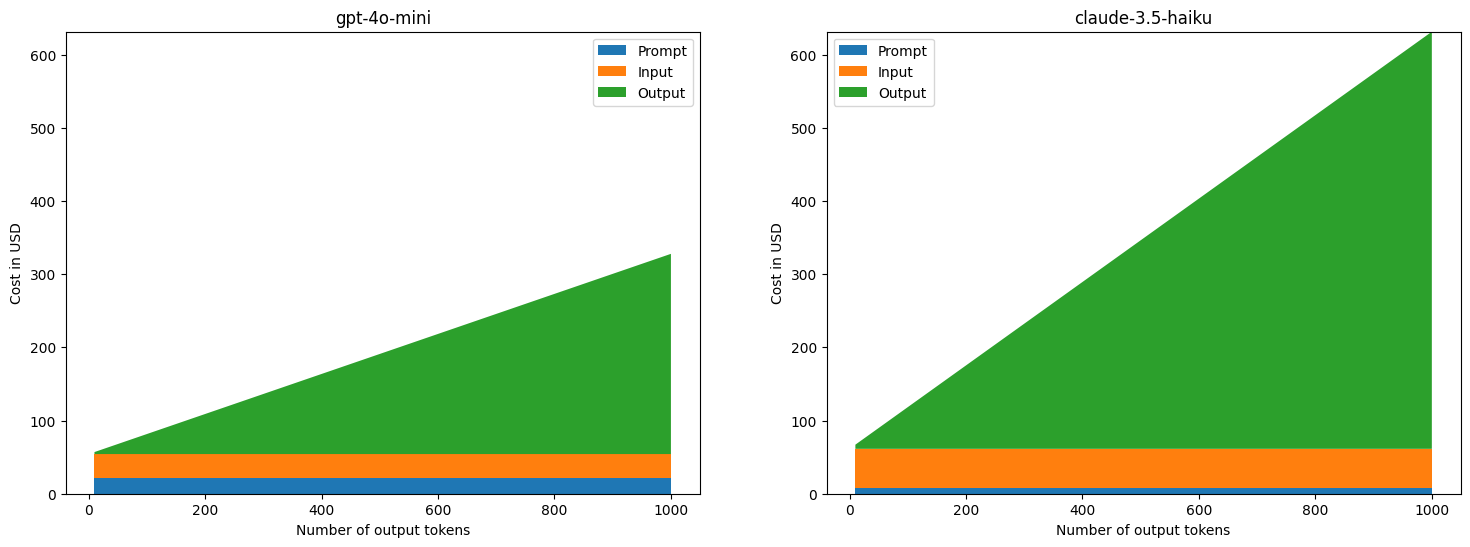

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for ax, model in zip(axes, pricing.keys()):
    tmp = costs[costs.model == model]
    ax.stackplot(output_tokens_range, tmp.prompt_cost, tmp.input_cost, tmp.output_cost, labels=["Prompt", "Input", "Output"])
    ax.set_xlabel("Number of output tokens")
    ax.set_ylabel('Cost in USD')
    ax.set_title(model)
    ax.set_ylim(0, costs.total_cost.max())
    ax.legend()

plt.show()